##***Chargement des données***

On commence par monter Google Drive pour accéder aux fichiers du projet. Le jeu de données est ensuite extrait depuis un fichier ZIP vers un dossier local, afin de le rendre accessible pour la suite du traitement.

In [1]:
from google.colab  import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

extract_path = "/content/urban_dataset"
os.makedirs(extract_path, exist_ok=True)

import zipfile

zip_path = "/content/drive/MyDrive/urban_street_scenes_understanding_dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Données extraites dans : {extract_path}")

Mounted at /content/drive
/content/drive/MyDrive
Données extraites dans : /content/urban_dataset


## **Vérification** **des** **fichier**

On se place dans le dossier contenant les données extraites et on liste son contenu pour s’assurer que tout a été correctement extrait.



In [7]:
%cd /content/urban_dataset
!ls  # pour vérifier le contenu extrait


/content/urban_dataset
train  val


##**Clustering** **des** **couleurs** **dans** **les** **masques**

Ce bloc implémente un pipeline complet pour extraire une palette de couleurs à partir des masques de segmentation.
Les étapes sont les suivantes :

**1.**Chargement des masques depuis un dossier donné.

**2.**Préparation des données en regroupant tous les pixels des masques.

**3.**Application de K-Means pour regrouper les couleurs en un nombre de classes (clusters) donné.

**4.**Affichage de la palette de couleurs obtenue.

**5.**Sauvegarde des résultats (centroïdes et labels) et génération d’un dictionnaire Python pour la palette.

**6.**Reconstruction visuelle d’un masque à partir des clusters pour illustrer le résultat du clustering.

200 masques chargés pour le clustering.
KMeans centers saved to 'kmeans_centers.npy'
KMeans labels saved to 'kmeans_labels.npy'
Palette des couleurs (RGB) :
Classe 0: [ 34 141 106]
Classe 1: [128  33  59]
Classe 2: [83  5  7]
Classe 3: [70 69 70]
Classe 4: [230  36 241]
Classe 5: [139 153 148]
Classe 6: [176 130  72]
Classe 7: [139   1   2]
Classe 8: [ 60  21 213]
Classe 9: [80  2 80]
Classe 10: [ 62 181 209]
Classe 11: [166 168 243]
Classe 12: [5 4 4]
Classe 13: [156 244 158]
Classe 14: [27 36 34]
Classe 15: [158  49 165]
Classe 16: [ 94 116 148]
Classe 17: [ 14  75 108]
Classe 18: [ 60 135 110]
Classe 19: [93 62 17]
Classe 20: [108 115  96]
Classe 21: [ 73  43 164]
Classe 22: [198  57 212]
Classe 23: [153 102 102]
Classe 24: [127  63 127]
Classe 25: [ 20 217 214]
Classe 26: [ 37  17 116]
Classe 27: [45 82 73]
Classe 28: [161 148 187]
Classe 29: [220   2   6]


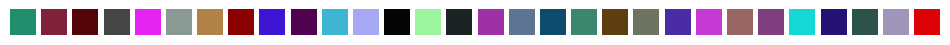

Palette sauvegardée dans 'palette.py' sous forme de dictionnaire Python.


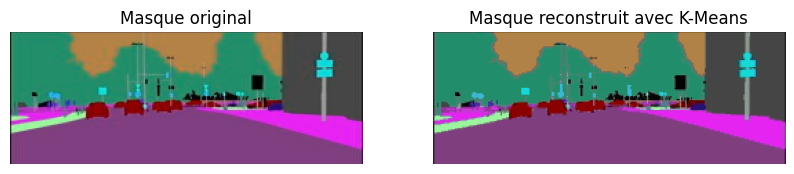

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import os
import random

# === 1. Charger les masques ===
def load_masks_from_folder(folder_path, max_images=None):
    masks = []
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]

    if max_images is not None:
        all_files = random.sample(all_files, min(max_images, len(all_files)))

    for filename in all_files:
        img = Image.open(os.path.join(folder_path, filename)).convert('RGB')
        masks.append(np.array(img))
    return masks


# === 2. Préparer les données pour KMeans ===

def prepare_pixel_data(masks):
    # Empiler tous les masques ensemble
    all_pixels = np.vstack([mask.reshape(-1, 3) for mask in masks])
    return all_pixels

# === 3. Appliquer KMeans ===

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    centers = kmeans.cluster_centers_
    return labels, centers

# === 4. Créer et afficher la palette de couleurs ===

def display_palette(centers):
    palette = np.clip(centers.astype(int), 0, 255)
    print("Palette des couleurs (RGB) :")
    for idx, color in enumerate(palette):
        print(f"Classe {idx}: {color}")

    # Visualiser la palette
    plt.figure(figsize=(12, 2))
    for idx, color in enumerate(palette):
        plt.subplot(1, len(palette), idx + 1)
        plt.imshow(np.ones((10, 10, 3), dtype=np.uint8) * color.astype(np.uint8))
        plt.axis('off')
    plt.show()

    return palette
def save_kmeans_results(centers, labels, centers_path="kmeans_centers.npy", labels_path="kmeans_labels.npy"):
    np.save(centers_path, centers)
    np.save(labels_path, labels)
    print(f"KMeans centers saved to '{centers_path}'")
    print(f"KMeans labels saved to '{labels_path}'")

def save_palette_as_dict(centers, save_path="palette.py"):
    palette_dict = {tuple(int(c) for c in color): idx for idx, color in enumerate(centers)}

    with open(save_path, "w") as f:
        f.write("PALETTE = {\n")
        for color, idx in palette_dict.items():
            f.write(f"    {color} : {idx},\n")
        f.write("}\n")

    print(f"Palette sauvegardée dans '{save_path}' sous forme de dictionnaire Python.")
# === 5. Reconstruire un masque propre avec la palette ===

def reconstruct_mask(mask, labels, centers, start_idx):
    height, width, _ = mask.shape
    n_pixels = height * width

    if start_idx + n_pixels > len(labels):
        raise ValueError(
            f"Trop de pixels demandés : start_idx={start_idx}, taille={n_pixels}, "
            f"mais seulement {len(labels)} labels disponibles."
        )

    mask_labels = labels[start_idx:start_idx + n_pixels]
    reconstructed_flat = centers[mask_labels]
    reconstructed_mask = reconstructed_flat.reshape(height, width, 3).astype(np.uint8)
    return reconstructed_mask

# === 6. Pipeline complet ===

def pipeline(folder_path, n_clusters=30, max_images=200):
    masks = load_masks_from_folder(folder_path, max_images=max_images)
    print(f"{len(masks)} masques chargés pour le clustering.")

    data = prepare_pixel_data(masks)
    labels, centers = apply_kmeans(data, n_clusters)
    save_kmeans_results(centers, labels)

    palette = display_palette(centers)
    save_palette_as_dict(palette, save_path="palette.py")

    # Visualisation d'un masque d'exemple reconstruit
    example_mask = masks[0]
    reconstructed = reconstruct_mask(example_mask, labels, centers, start_idx=0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(example_mask)
    plt.title("Masque original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Masque reconstruit avec K-Means")
    plt.axis("off")

    plt.show()


# === Utilisation ===

folder_path = "train/label"
pipeline(folder_path, n_clusters=30,max_images=200)

##**Autre version de calcul de la palette avec un autoencoder**
Le pipeline ci-dessous propose une approche non supervisée d'extraction de palette en utilisant un **autoencoder neuronal**. Cette méthode vise à apprendre une représentation compacte des couleurs présentes dans les masques, puis à en déduire une **palette représentative**. <br>
**1.** Échantillonnage des couleurs à partir des masques de segmentation en utilisant la bibliothèque PIL :
Pour chaque image, un sous-échantillon aléatoire de pixels est effectué (500 pixels par masque sur 50 masques). Les couleurs sont ensuite normalisées entre 0 et 1. <br>
**2.** Construction et entraînement d’un autoencodeur : <br>
L’autoencodeur est constitué de plusieurs couches denses. La couche centrale utilise une activation softmax sur n neurones, représentant ainsi les 30 classes de notre jeu de données. L’objectif est que le modèle apprenne à reconstruire les couleurs d'entrée en passant par ces classes intermédiaires.<br>
**3.** Extraction des couleurs représentatives :
Une fois le modèle entraîné, les vecteurs encodés sont projetés via np.argmax pour récupérer l'identifiant de la classe la plus activée. On calcule alors la moyenne des couleurs par classe, puis on sélectionne une couleur représentative par groupe (celle la plus proche du centroïde du cluster).<br>
**4.** Affichage de la palette apprise et sauvegarde au format JSON :
La palette finale est affichée et enregistrée pour être réutilisée. Chaque couleur est associée à un identifiant de classe.<br>
**5.** Reconstruction visuelle d’un masque à partir des clusters pour illustrer le résultat de l'apprentissage. <br>
**6.** Visualisation t-SNE des représentations encodées :
Projection des représentation t-SNE pour observer les regroupements naturels. <br>  

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0596
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433
Epoch 3/30
 1/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0343

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3568e-04
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1783e-04
Epoch 9/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7902e-04
Epoch 10/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8809e-04
Epoch 11/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1996e-04
Epoch 12/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7423e-04
Epoch 13/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4787e-04
Epoch 14/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2165e-04
Epoch 15/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0618e-04
Epoch 16/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9412e-04
Epoch 17/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

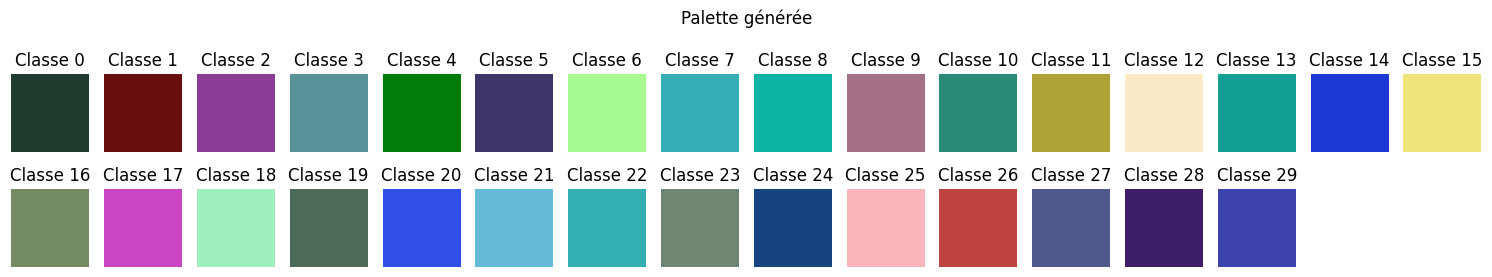

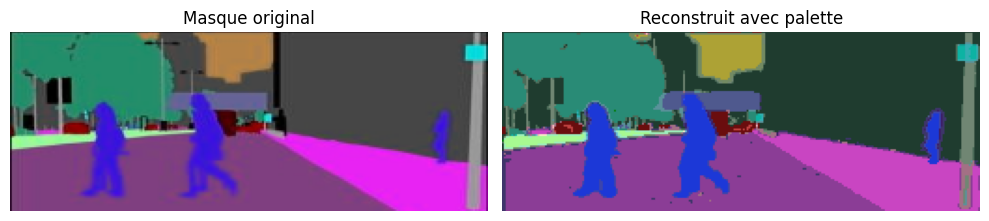

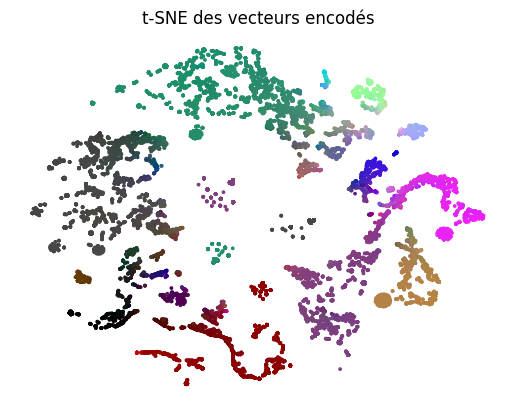

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

# === 1. Chargement et échantillonnage des couleurs ===
def sample_colors_from_masks(label_dir, n_images=50, pixels_per_image=500):
    all_colors = []
    for filename in os.listdir(label_dir)[:n_images]:
        path = os.path.join(label_dir, filename)
        img = np.array(Image.open(path))
        if img.ndim == 3:
            flat = img.reshape(-1, 3)
            idx = np.random.choice(len(flat), pixels_per_image, replace=False)
            all_colors.append(flat[idx])
    return np.concatenate(all_colors, axis=0) / 255.0

# === 2. Création de l'autoencodeur ===
def create_color_autoencoder(n_classes=30):
    input_img = layers.Input(shape=(3,))
    encoded = layers.Dense(64, activation='relu')(input_img)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(n_classes, activation='softmax')(encoded)

    decoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(3, activation='sigmoid')(decoded)

    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# === 3. Entraînement de l'autoencodeur ===
def train_autoencoder(autoencoder, all_colors, epochs=30, batch_size=512):
    callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    history = autoencoder.fit(
        all_colors, all_colors,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[callback]
    )
    return history

# === 4. Couleurs représentatives par classe encodée ===
def find_representative_colors(encoder, all_colors, n_classes=30):
    class_probs = encoder.predict(all_colors, verbose=0)
    class_ids = np.argmax(class_probs, axis=1)
    representative_colors = []
    for c in range(n_classes):
        mask = (class_ids == c)
        if np.sum(mask) == 0:
            representative_colors.append(np.random.rand(3))
        else:
            group = all_colors[mask]
            centroid = np.mean(group, axis=0)
            distances = np.linalg.norm(group - centroid, axis=1)
            representative_colors.append(group[np.argmin(distances)])
    return np.array(representative_colors)

# === 5. Visualisation de la palette ===
def display_palette(colors, title="Palette générée"):
    plt.figure(figsize=(15, 3))
    for i, color in enumerate(colors):
        plt.subplot(2, len(colors)//2 + 1, i+1)
        plt.imshow([[np.clip(color, 0, 1)]])
        plt.title(f"Classe {i}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# === 6. Reconstruction d'une image avec une palette ===
def reconstruct_with_palette(image, palette):
    img_np = np.array(image)
    h, w, _ = img_np.shape
    img_flat = img_np.reshape(-1, 3).astype(np.float32)
    img_lab = color.rgb2lab(img_flat.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)
    pal_lab = color.rgb2lab(np.array(palette).reshape(-1, 1, 3) / 255.0).reshape(-1, 3)
    distances = cdist(img_lab, pal_lab)
    nearest_indices = np.argmin(distances, axis=1)
    remapped = np.array(palette)[nearest_indices].reshape(h, w, 3).astype(np.uint8)
    return remapped

# === 7. Sauvegarde en JSON ===
def save_palette_as_json(colors, path):
    import json
    colors_255 = (colors * 255).astype(int).tolist()
    palette_dict = {f"class_{i}": color for i, color in enumerate(colors_255)}
    with open(path, 'w') as f:
        json.dump(palette_dict, f, indent=2)

# === 8. Pipeline complet ===
def autoencoder_palette_pipeline(label_dir, n_classes=30):
    colors = sample_colors_from_masks(label_dir)
    autoencoder, encoder = create_color_autoencoder(n_classes)
    train_autoencoder(autoencoder, colors)
    rep_colors = find_representative_colors(encoder, colors, n_classes)
    display_palette(rep_colors)
    save_palette_as_json(rep_colors, "auto_palette.json")
    # === Reconstruction d’un exemple ===
    example_path = os.path.join(label_dir, os.listdir(label_dir)[0])
    example_img = Image.open(example_path).convert("RGB")
    reconstructed = reconstruct_with_palette(example_img, (rep_colors * 255).astype(np.uint8))

    # Affichage
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(example_img)
    plt.title("Masque original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstruit avec palette")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    encoded_vectors = autoencoder.predict(colors, verbose=0)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    proj = tsne.fit_transform(encoded_vectors)

    plt.scatter(proj[:, 0], proj[:, 1], c=colors, s=3)
    plt.title("t-SNE des vecteurs encodés")
    plt.axis("off")
    plt.show()
    # return rep_colors

# === Utilisation ===
label_dir = "train/label"
autoencoder_palette_pipeline(label_dir, n_classes=30)


##**Autre version de calcul de la palette avec DBSCAN**
Le bloc ci-dessous implémente le pipeline d'un calcul de palette. Les couleurs des masques sont d'abord extraits à partir des masques disponibles dans nos données d'entraînement, sur ces couleurs extraites () est appliqué un DBSCAN. Pour arriver à une meilleure palette, plusieurs valeurs de distances (eps) ont été testées. Finalement les couleurs ont été comparées à une palette de cityscape trouvée en ligne et corrigée manuellement pour que les couleurs matchent le mieux avec nos masques. <br>
**1.** Récupération de toutes les couleurs à l'aide de la bibliothèque PIL et échantillonnage sur les plus fréquentes (après plusieurs tests, nous avons choisi 100000 sur les 221718 couleurs de départ)<br>
**2.** Application d'un DBSCAN, un algorithme de clustering non supervisé, qui nous renvoie les couleurs entrées selon les clusters puis fait une moyenne des couleurs de ces derniers pour ne renvoyer qu'une couleurs. <br>
**3.** Chargement de la palette trouvée ici : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py et ajustée manuellement à nos couleurs présentes sur les masques <br>
**4.** Comparaison des couleurs extraites par le DBSCAN à la palette <br>
**5.** Enregistrement de la palette trouvée au format json <br>
**6.** Reconstruction visuelle d’un masque à partir des clusters pour illustrer le résultat du clustering.

Il y a 6266 couleurs après application du DBSCAN


None

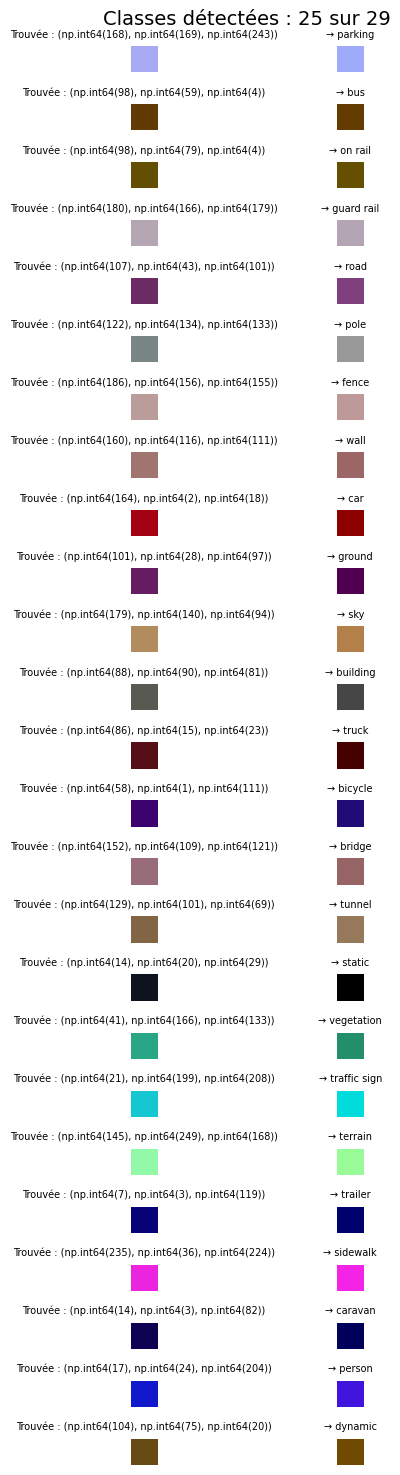

Mapping enregistré dans label_color_mapping.json


None

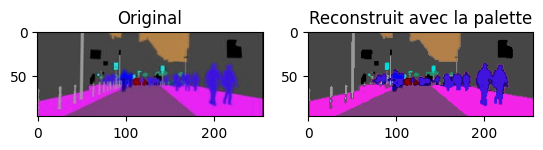

In [ ]:
from PIL import Image, ImageFilter
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
from skimage import color
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cdist
import json

# === 1. Récupérer les couleurs les plus communes des masques ===
def get_most_common_colors_from_dataset(mask_folder, nbColor):
  all_colors = Counter()
  for file in os.listdir(mask_folder):
      if file.endswith(".png"):
          img = Image.open(os.path.join(mask_folder, file))
          img_filtered = img.filter(ImageFilter.MedianFilter(size=3))
          quantized = img.convert("P", palette=Image.ADAPTIVE, colors=256)
          palette = quantized.getpalette()
          used_indices = set(quantized.getdata())

          for idx in used_indices:
              color = tuple(palette[3*idx:3*idx+3])
              all_colors[color] += 1

  # Couleurs les plus fréquentes
  top_colors = all_colors.most_common(nbColor)
  raw_colors = []
  for i, (color, count) in enumerate(top_colors):
      raw_colors.append(color)
  return raw_colors

# === 2. Appliquer le DBSCAN sur les couleurs les plus fréquentes ===
def apply_DBSCAN_on_colors(raw_colors, eps):
  rgb_array = np.array(raw_colors, dtype=np.uint8).reshape(-1, 1, 3) / 255.0
  lab_array = color.rgb2lab(rgb_array).reshape(-1, 3)

  clustering = DBSCAN(eps=eps, min_samples=1).fit(lab_array)
  labels = clustering.labels_
  clusters = defaultdict(list)
  for idx, label in enumerate(labels):
      clusters[label].append(raw_colors[idx])

  # Prendre la moyenne des couleurs de chaque cluster comme couleur canonique
  cluster_representatives = []
  for group in clusters.values():
      avg_color = tuple(np.mean(group, axis=0).astype(int))
      cluster_representatives.append(avg_color)
  return cluster_representatives

# === 3. Chargement de la palette ===
reference_palette = {
    'dynamic': (111, 74,  0), # Correct
    'ground': (81, 0, 81), # Correct
    'road': (128, 64,128), # Correct
    'sidewalk': (244, 35,232), # Correct
    'parking': (160,170,250), # Correct
    'on rail': (230,150,140) ,
    'building': ( 70, 70, 70), # Correct
    'wall': (156,102,102), # Correct
    'fence': (190,153,153),
    'guard rail': (180,165,180),
    'bridge': (150,100,100),
    'tunnel' : (150,120, 90),
    'pole'         : (153,153,153), # Correct
    'polegroup'    : (153,153,153), # Correct
    'traffic light': (33,167, 253), # Correct
    'traffic sign' : (0, 220, 220), # Correct
    'vegetation'   : (34,142, 106), # Correct
    'terrain'      : (152,251,152), # Correct
    'sky'          : ( 179,128,74), # Correct
    'person'       : (65, 20, 222), # Correct
    'rider'        : (0, 0, 255), # Correct
    'car'          : (  142,  0,0), # Correct
    'truck'        : (  70,  0, 0), # Correct
    'bus'          : (  100, 60, 0), # Correct
    'caravan'      : (  0,  0, 90),
    'trailer'      : (  0,  0,110),
    'on rail'        : (  100, 80, 0), # Correct
    'motorcycle'   : (  0,  0,230),
    'bicycle'      : (32, 11, 119), # Correct
    'static': (  0,  0, 0) # Correct
}

# === 4. Comparaison avec la palette  ===
def match_colors_to_reference(cluster_representatives, reference_palette, threshold=10, show=True):
    ref_colors = np.array(list(reference_palette.values()), dtype=np.uint8)
    ref_labels = list(reference_palette.keys())
    ref_lab = color.rgb2lab(ref_colors.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)

    def match_color_to_label(color_rgb):
        color_lab = color.rgb2lab(np.array(color_rgb).reshape(1, 1, 3) / 255.0).reshape(1, 3)
        distances = cdist(color_lab, ref_lab)
        min_dist = np.min(distances)
        if min_dist < threshold:
            idx = np.argmin(distances)
            return ref_labels[idx], tuple(ref_colors[idx]), min_dist
        else:
            return None, None, min_dist

    seen_labels = set()
    filtered_matches = []

    for color_rgb in cluster_representatives:
        label, ref_rgb, dist = match_color_to_label(color_rgb)
        if label and label not in seen_labels:
            seen_labels.add(label)
            filtered_matches.append((color_rgb, ref_rgb, label))

    if show:
        fig, axs = plt.subplots(len(filtered_matches), 2, figsize=(6, len(filtered_matches) * 0.6))
        fig.suptitle(f"Classes détectées : {len(filtered_matches)} sur {len(reference_palette)}", fontsize=14)

        for i, (color_rgb, ref_rgb, label) in enumerate(filtered_matches):
            axs[i, 0].imshow(np.full((10, 10, 3), color_rgb, dtype=np.uint8))
            axs[i, 0].set_title(f"Trouvée : {color_rgb}", fontsize=7)
            axs[i, 0].axis("off")

            axs[i, 1].imshow(np.full((10, 10, 3), ref_rgb, dtype=np.uint8))
            axs[i, 1].set_title(f"→ {label}", fontsize=7)
            axs[i, 1].axis("off")

        plt.tight_layout()
        plt.show()

    return filtered_matches

# === 5. Enregistrement dans un dictionnaire et sauvegarde de la palette  ===
def transform_to_dict_and_save(savedir, palette):
  class NpEncoder(json.JSONEncoder):
      def default(self, obj):
          if isinstance(obj, np.integer):
              return int(obj)
          if isinstance(obj, np.floating):
              return float(obj)
          if isinstance(obj, np.ndarray):
              return obj.tolist()
          return super(NpEncoder, self).default(obj)

  # Dictionnaire {label: couleur détectée}
  output_mapping = {label: list(color_rgb) for color_rgb, _, label in palette}

  # Enregistrer dans un fichier
  with open(os.path.join(savedir, "label_color_mapping.json"), "w") as f:
      json.dump(output_mapping, f, indent=4, cls=NpEncoder)

  display(print("Mapping enregistré dans label_color_mapping.json"))

# === 6. Reconstruction visuelle d'une image à partir de la palelle ===
def reconstruct_with_palette(image, palette):
    img_np = np.array(image)
    h, w, _ = img_np.shape
    img_flat = img_np.reshape(-1, 3).astype(np.float32)

    img_lab = color.rgb2lab(img_flat.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)
    pal_lab = color.rgb2lab(np.array(palette).reshape(-1, 1, 3) / 255.0).reshape(-1, 3)

    distances = cdist(img_lab, pal_lab)
    nearest_indices = np.argmin(distances, axis=1)
    remapped = np.array(palette)[nearest_indices].reshape(h, w, 3).astype(np.uint8)

    return remapped

mask_dir = "train/label"
most_commons = get_most_common_colors_from_dataset(mask_dir, 100000)
representation = apply_DBSCAN_on_colors(most_commons, 1.5)
display(print(f"Il y a {len(representation)} couleurs après application du DBSCAN"))
matched = match_colors_to_reference(representation, reference_palette, threshold=10)
transform_to_dict_and_save("", matched)
image = Image.open("train/label/train1001.png").convert("RGB")
reconstructed = reconstruct_with_palette(image, [ref for ref in reference_palette.values()])

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title("Reconstruit avec la palette")
plt.show()

##**Nettoyage** **et** **normalisation** **des** **masques**
Cette étape consiste à associer chaque pixel des masques originaux à la couleur la plus proche dans la palette définie précédemment, afin de produire des masques propres avec des classes bien identifiées.
Les masques nettoyés sont sauvegardés dans un nouveau dossier, puis une visualisation aléatoire permet de comparer le Ground Truth d’origine avec la version nettoyée.



In [ ]:
import numpy as np
from palette import PALETTE
import matplotlib.pyplot as plt

palette_colors = np.array(list(PALETTE.keys()))
labels = list(PALETTE.values())


from scipy.spatial import distance

def load_kmeans_results(centers_path="kmeans_centers.npy", labelwWs_path="kmeans_labels.npy"):
    centers = np.load(centers_path)
    labels = np.load(labels_path)
    return centers, labels

# === Fonction de mapping ===
def map_to_nearest_palette_color(mask_array, palette_colors, palette_mapping):
    pixels = mask_array.reshape(-1, 3)
    dists = distance.cdist(pixels, palette_colors, 'euclidean')
    nearest_palette_idx = np.argmin(dists, axis=1)
    class_indices = np.array([palette_mapping[tuple(color)] for color in palette_colors])[nearest_palette_idx]
    return class_indices.reshape(mask_array.shape[:2])

# === Traitement de tous les masques dans un dossier ===
def process_masks(input_dir, output_dir, palette_colors, palette_mapping):
    os.makedirs(output_dir, exist_ok=True)
    processed_files = []

    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            mask_path = os.path.join(input_dir, filename)
            mask = Image.open(mask_path).convert('RGB')
            mask_np = np.array(mask)


            class_mask = map_to_nearest_palette_color(mask_np, palette_colors, palette_mapping)

            output_path = os.path.join(output_dir, filename)
            Image.fromarray(class_mask.astype(np.uint8)).save(output_path)

            processed_files.append(output_path)

    print(f"{len(processed_files)} masques ont été nettoyés et sauvegardés dans {output_dir} !")
    return processed_files


# === Directories ===
seg_dir = folder_path
output_dir = "cleaned_masks"
os.makedirs(output_dir, exist_ok=True)
# === Process all masks ===
processed_files = process_masks(seg_dir, output_dir, palette_colors, PALETTE)

# == process all masks == #
import random
# === Visualisation aléatoire avec comparaison avant/après ===


def visualize_random_masks(processed_files, original_masks_dir, num_samples=10):
    """
    Visualisation aléatoire de masques nettoyés avec comparaison au Ground Truth original.

    Args:
        processed_files (list): Liste des chemins des masques nettoyés.
        original_masks_dir (str): Dossier contenant les masques originaux RGB.
        num_samples (int): Nombre d'exemples à visualiser (par défaut 10).
    """
    # Sélectionner des fichiers aléatoires
    random_files = random.sample(processed_files, min(num_samples, len(processed_files)))

    plt.figure(figsize=(15, 5 * len(random_files)))

    for idx, file in enumerate(random_files):
        # Chargement du masque nettoyé
        cleaned_mask = Image.open(file)

        # Chargement du masque original (RGB)
        original_file = os.path.basename(file)
        original_path = os.path.join(original_masks_dir, original_file)
        original_mask = Image.open(original_path).convert('RGB')

        # Affichage du Ground Truth
        plt.subplot(len(random_files), 2, idx * 2 + 1)
        plt.imshow(original_mask)
        plt.title(f'Ground Truth: {original_file}')
        plt.axis('off')

        # Affichage du masque nettoyé
        plt.subplot(len(random_files), 2, idx * 2 + 2)
        plt.imshow(cleaned_mask, cmap='nipy_spectral')
        unique_values = np.unique(np.array(cleaned_mask))
        print(f"Valeurs uniques dans le masque ({original_file}):", unique_values)
        plt.title(f'Masque nettoyé: {original_file}')
        plt.axis('off')

    plt.suptitle('Comparaison Ground Truth vs Masques nettoyés', fontsize=18)
    plt.tight_layout()
    plt.show()

visualize_random_masks(processed_files, seg_dir, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.

##**Traitement des masques de test**
Les masques de l’ensemble de test sont nettoyés à l’aide de la palette précédemment définie. Une visualisation aléatoire permet de comparer les masques d’origine avec leur version nettoyée.

In [ ]:
# === Directories ===
test_dir = "val"
seg_test_dir = test_dir + "/label"
output_test_dir = "cleaned_test_masks"
os.makedirs(output_test_dir, exist_ok=True)
# === Process all masks ===
processed_test_files = process_masks(seg_test_dir, output_test_dir, palette_colors, PALETTE)
visualize_random_masks(processed_test_files, seg_test_dir, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.

##**Chargement des images et masques nettoyés**
Les images RGB d'entraînement ainsi que les masques nettoyés correspondants sont chargés et transformés en tableaux NumPy. Les images sont normalisées entre 0 et 1 pour préparation à l'entraînement d'un modèle.

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):  # on trie pour aligner images et masques
        if filename.endswith('.png') :
            img = Image.open(os.path.join(folder, filename)).convert('RGB')
            img = np.array(img) / 255.0  # Normalisation entre 0 et 1
            images.append(img)
    return np.array(images)

def load_masks_from_folder(folder):
    masks = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            mask = Image.open(os.path.join(folder, filename))
            mask = np.array(mask)
            masks.append(mask)
    return np.array(masks)

# Utilisation
train_image_dir = "train/img"
train_mask_dir = "cleaned_masks"

x_train = load_images_from_folder(train_image_dir)
y_train = load_masks_from_folder(train_mask_dir)

print(f"Images shape: {x_train.shape}")
print(f"Masks shape: {y_train.shape}")

Images shape: (2975, 96, 256, 3)
Masks shape: (2975, 96, 256)


##**Calcul des poids de classes**
Pour compenser le déséquilibre entre classes dans les masques, on calcule des poids inverses à leur fréquence d’apparition (avec lissage). Ces poids serviront lors de l’entraînement pour accorder plus d’importance aux classes rares.



In [ ]:

import numpy as np

# Aplatir y_train
y_train_flat = y_train.flatten()

# Trouver le nombre de pixels par classe
pixel_counts = np.bincount(y_train_flat, minlength=30)

# Calculer les proportions
total_pixels = np.sum(pixel_counts)
class_proportions = pixel_counts / total_pixels

# Lissage
epsilon = 1.02
class_weights = 1 / (np.log(epsilon + class_proportions))

# Créer le dictionnaire
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weights_dict)



{0: np.float64(16.097634133113697), 1: np.float64(4.371512665738407), 2: np.float64(4.409714749022416), 3: np.float64(6.393633399107062), 4: np.float64(12.594918942782105), 5: np.float64(36.52830992328494), 6: np.float64(35.242606821025156), 7: np.float64(30.698310036233707), 8: np.float64(31.75595594497716), 9: np.float64(26.35022975919562), 10: np.float64(33.62186144877728), 11: np.float64(36.77984245321098), 12: np.float64(40.45797673621516), 13: np.float64(40.580508884413035), 14: np.float64(21.84289741086241), 15: np.float64(42.720220231251645), 16: np.float64(29.647994122614183), 17: np.float64(17.285175399761883), 18: np.float64(32.170970200374256), 19: np.float64(42.35901711115304), 20: np.float64(39.46753309190492), 21: np.float64(34.46385901309434), 22: np.float64(28.79291580815468), 23: np.float64(41.76353138113673), 24: np.float64(31.963564242550625), 25: np.float64(39.65414465250583), 26: np.float64(31.51359991190528), 27: np.float64(35.65600468008134), 28: np.float64(41.5

##**Fonction de perte pondérée**
Cette fonction de perte applique une cross-entropy pondérée, ce qui permet de compenser le déséquilibre entre classes en attribuant un poids plus élevé aux classes peu représentées. Cela aide le modèle à mieux apprendre l’ensemble des classes du jeu de données.

In [ ]:
import tensorflow as tf

def weighted_categorical_crossentropy(class_weights):
    """
    Weighted Categorical Crossentropy only.

    Args:
        class_weights: array or list of class weights

    Returns:
        A custom loss function
    """
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))  # (batch, height, width, num_classes)

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Pour éviter log(0)

        # Weighted categorical cross-entropy
        cross_entropy = -tf.reduce_sum(class_weights * y_true_one_hot * tf.math.log(y_pred), axis=-1)

        return tf.reduce_mean(cross_entropy)

    return loss

# Exemple d'utilisation
loss_fn = weighted_categorical_crossentropy(class_weights)


##**Définition du modèle U-Net**
Un modèle U-Net est défini pour effectuer la segmentation sémantique pixel par pixel. Il comporte un encodeur, un goulot d’étranglement, puis un décodeur avec des connexions de type "skip connections" pour préserver l’information spatiale.

Deux versions du modèle sont compilées :

Une avec la cross-entropy standard.

Une avec la fonction de perte pondérée intégrant les poids de classes, utilisée pour entraîner un modèle plus robuste face au déséquilibre.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape=(96, 256, 3), num_classes=30):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='bottleneck_conv')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Créer le modèle
model_unet = unet_model()

# Compiler le modèle
model_unet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_unet_weighted = unet_model()
model_unet_weighted.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

# Afficher le résumé
model_unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 256,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 256,   │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 256,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 128,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 128,   │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_conv     │ (None, 12, 32,    │  1,180,160 │ max_pooling2d_2[… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 32,    │  2,359,808 │ bottleneck_conv[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 24, 64,    │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 64,    │    590,080 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 48, 128,   │          0 │ conv2d_8[0][0]  

 Total params: 7,784,798 (29.70 MB)

 Trainable params: 7,784,798 (29.70 MB)

 Non-trainable params: 0 (0.00 B)

##**Entraînement du modèle**
Les deux versions du modèle U-Net sont entraînées sur les données d’apprentissage pendant 25 époques avec un batch size de 16. Une partie des données (20 %) est utilisée pour la validation afin de suivre les performances au fil des époques.

In [ ]:
history_unet = model_unet.fit(x_train, y_train, epochs=25, batch_size=16, validation_split=0.2)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 96, 256, 3))
  warnings.warn(msg)


149/149 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.2959 - loss: 2.6026 - val_accuracy: 0.5956 - val_loss: 1.5612
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 285ms/step - accuracy: 0.5980 - loss: 1.5154 - val_accuracy: 0.6656 - val_loss: 1.2538
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 80s 270ms/step - accuracy: 0.6656 - loss: 1.2713 - val_accuracy: 0.6854 - val_loss: 1.1667
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 283ms/step - accuracy: 0.6957 - loss: 1.1526 - val_accuracy: 0.7126 - val_loss: 1.0734
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 283ms/step - accuracy: 0.7182 - loss: 1.0566 - val_accuracy: 0.7224 - val_loss: 1.0148
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 274ms/step - accuracy: 0.7302 - loss: 1.0044 - val_accuracy: 0.7384 - val_loss: 0.9477
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 0.7459 - loss: 0.9407 - val_accuracy: 0.7505 - val_loss: 0.9019
Epoch 8/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 0.7535 - loss: 0.9032 - va

In [ ]:
model_unet.save("model_unet.keras")
import json

with open("history_unet.json", "w") as f:
    json.dump(history_unet.history, f)

In [ ]:
history_unet_weighted = model_unet_weighted.fit(x_train, y_train, epochs=25, batch_size=16, validation_split=0.2)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 96, 256, 3))
  warnings.warn(msg)


149/149 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.2996 - loss: 40.6897 - val_accuracy: 0.5656 - val_loss: 28.7942
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 72s 273ms/step - accuracy: 0.5683 - loss: 28.8428 - val_accuracy: 0.6363 - val_loss: 25.6448
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 0.6165 - loss: 25.9979 - val_accuracy: 0.6538 - val_loss: 24.0359
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.6433 - loss: 24.2797 - val_accuracy: 0.6580 - val_loss: 22.9735
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 283ms/step - accuracy: 0.6608 - loss: 22.9933 - val_accuracy: 0.7007 - val_loss: 20.9113
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 80s 273ms/step - accuracy: 0.6776 - loss: 21.4235 - val_accuracy: 0.6835 - val_loss: 20.6018
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.6847 - loss: 20.8281 - val_accuracy: 0.6970 - val_loss: 20.5622
Epoch 8/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - accuracy: 0.6903 - loss

In [ ]:
model_unet_weighted.save("model_unet_weighted.keras")

with open("history_unet_weighted.json", "w") as f:
    json.dump(history_unet_weighted.history, f)

##**Chargement des données de test**
Les images de test et leurs masques nettoyés sont chargés pour permettre l’évaluation finale du modèle sur des données non vues pendant l’entraînement.

In [ ]:
x_test = load_images_from_folder("val/img")
y_test = load_masks_from_folder("cleaned_test_masks")


##**Prédictions sur les données de test**



In [ ]:

# Prédictions sur toutes les images de test
predictions = model_unet.predict(x_test)

# Conversion des probabilités en classes (index de la classe avec la probabilité max)
predicted_masks = np.argmax(predictions, axis=-1)

print("Shape des masques prédits :", predicted_masks.shape)  # (num_images, 96, 256)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 96, 256, 3))
  warnings.warn(msg)


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 96, 256, 3))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
Shape des masques prédits : (500, 96, 256)


In [ ]:

# Prédictions sur toutes les images de test
predictions_weighted = model_unet_weighted.predict(x_test)

# Conversion des probabilités en classes (index de la classe avec la probabilité max)
predicted_masks_weighted = np.argmax(predictions_weighted, axis=-1)

print("Shape des masques prédits :", predicted_masks_weighted.shape)  # (num_images, 96, 256)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(32, 96, 256, 3))
  warnings.warn(msg)


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 96, 256, 3))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step
Shape des masques prédits : (500, 96, 256)


##**Comparaison des performances des deux modèles**
On compare ici les prédictions du modèle standard et du modèle entraîné avec des poids de classes. Plusieurs échantillons sont affichés pour visualiser les différences, et les courbes d’apprentissage sont tracées. Enfin, un rapport de classification global permet d’évaluer la qualité des prédictions de chaque modèle.

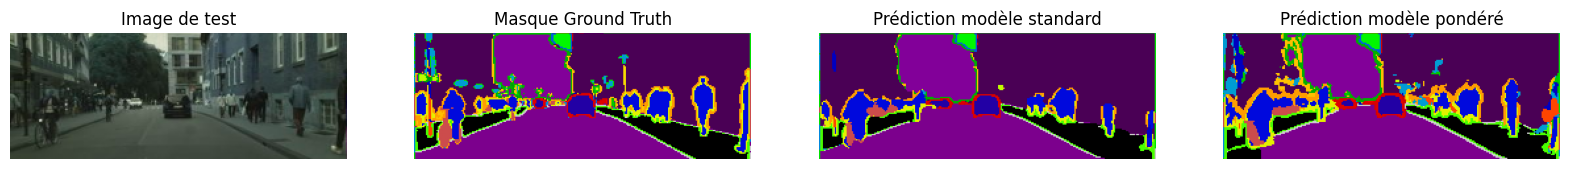

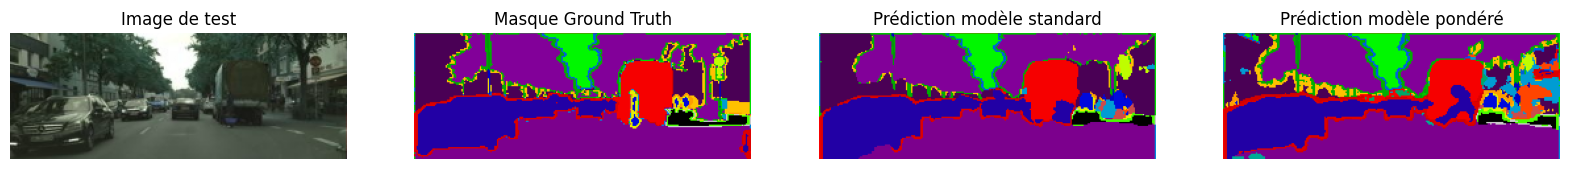

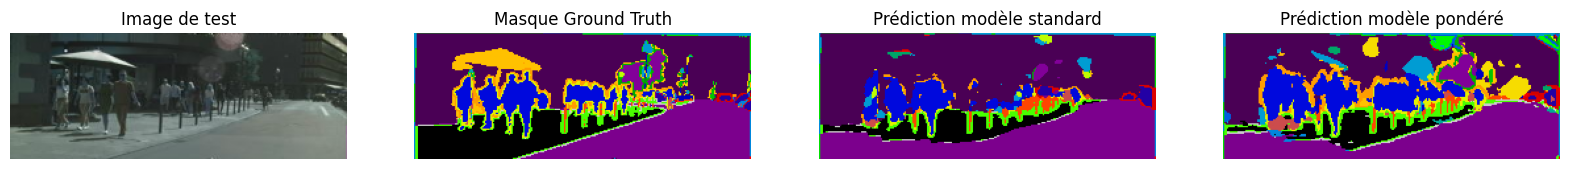

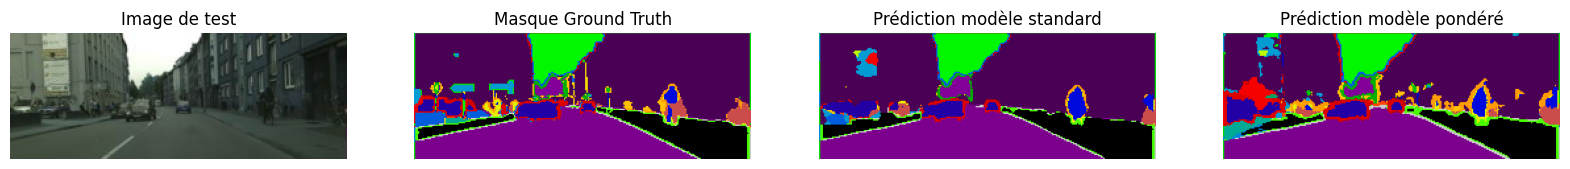

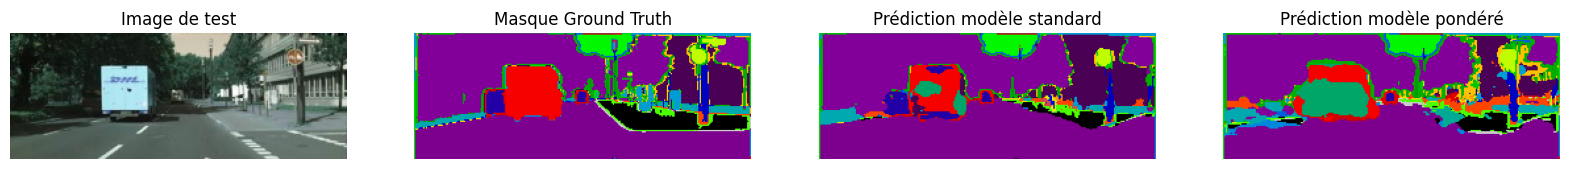

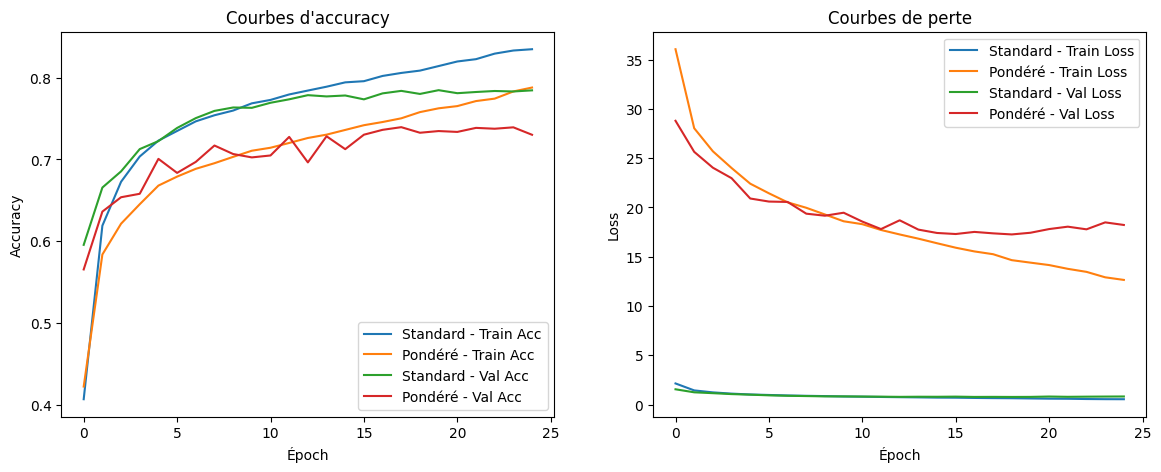


=== Rapport de classification - Modèle standard ===
              precision    recall  f1-score   support

           0       0.65      0.73      0.68    475457
           1       0.76      0.93      0.83   2746977
           2       0.89      0.95      0.92   3032906
           3       0.86      0.90      0.88   1964645
           4       0.80      0.91      0.85    701835
           5       0.45      0.14      0.22     97491
           6       0.43      0.69      0.53    119889
           7       0.50      0.26      0.34    160884
           8       0.29      0.09      0.13    185477
           9       0.48      0.35      0.40    275643
          10       0.50      0.59      0.54     89770
          11       0.25      0.22      0.23     51441
          12       0.52      0.42      0.47     64135
          13       0.55      0.09      0.16     69767
          14       0.50      0.30      0.38    358010
          15       0.27      0.09      0.14     49901
          16       0.82     

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import random

def compare_model_performance(x_test, y_test, preds_model1, preds_model2, history1=None, history2=None, class_names=None, num_samples=5):
    # === 1. Visualisation d'exemples ===
    indices = random.sample(range(x_test.shape[0]), num_samples)

    for idx in indices:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(x_test[idx])
        plt.title("Image de test")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(y_test[idx], cmap='nipy_spectral')
        plt.title("Masque Ground Truth")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(preds_model1[idx], cmap='nipy_spectral')
        plt.title("Prédiction modèle standard")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(preds_model2[idx], cmap='nipy_spectral')
        plt.title("Prédiction modèle pondéré")
        plt.axis('off')

        plt.show()

    # === 2. Courbes de performance ===
    if history1 and history2:
        plt.figure(figsize=(14, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history1.history['accuracy'], label='Standard - Train Acc')
        plt.plot(history2.history['accuracy'], label='Pondéré - Train Acc')
        if 'val_accuracy' in history1.history:
            plt.plot(history1.history['val_accuracy'], label='Standard - Val Acc')
        if 'val_accuracy' in history2.history:
            plt.plot(history2.history['val_accuracy'], label='Pondéré - Val Acc')
        plt.title("Courbes d'accuracy")
        plt.xlabel("Époch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history1.history['loss'], label='Standard - Train Loss')
        plt.plot(history2.history['loss'], label='Pondéré - Train Loss')
        if 'val_loss' in history1.history:
            plt.plot(history1.history['val_loss'], label='Standard - Val Loss')
        if 'val_loss' in history2.history:
            plt.plot(history2.history['val_loss'], label='Pondéré - Val Loss')
        plt.title("Courbes de perte")
        plt.xlabel("Époch")
        plt.ylabel("Loss")
        plt.legend()

        plt.show()

    # === 3. Rapport de classification ===
    print("\n=== Rapport de classification - Modèle standard ===")
    print(classification_report(y_test.flatten(), preds_model1.flatten(), target_names=class_names if class_names else None))

    print("\n=== Rapport de classification - Modèle pondéré ===")
    print(classification_report(y_test.flatten(), preds_model2.flatten(), target_names=class_names if class_names else None))
compare_model_performance(x_test, y_test, predicted_masks, predicted_masks_weighted, history1=history_unet, history2=history_unet_weighted, class_names=None, num_samples=5)

##**Définition du modèle DeepLabV3+**
Ce modèle utilise un backbone ResNet50 pré-entraîné pour extraire les caractéristiques de haut niveau, enrichies ensuite par un module ASPP (Atrous Spatial Pyramid Pooling). Un décodeur affine les détails spatiaux à l’aide de caractéristiques de bas niveau et effectue une segmentation pixel par pixel via une sortie softmax.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def atrous_spatial_pyramid_pooling(x, filters):
    """ASPP block with different atrous rates."""
    # 1x1 conv
    conv_1x1 = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)

    # Atrous Convolutions with different rates
    conv_3x3_r6  = layers.Conv2D(filters, 3, dilation_rate=6, padding='same', activation='relu')(x)
    conv_3x3_r12 = layers.Conv2D(filters, 3, dilation_rate=12, padding='same', activation='relu')(x)
    conv_3x3_r18 = layers.Conv2D(filters, 3, dilation_rate=18, padding='same', activation='relu')(x)

    # Image-level features via global average pooling
    gap = layers.GlobalAveragePooling2D()(x)
    gap = layers.Reshape((1, 1, x.shape[-1]))(gap)
    gap = layers.Conv2D(filters, 1, padding='same', activation='relu')(gap)
    gap = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(gap)

    # Concatenate all branches
    x = layers.Concatenate()([conv_1x1, conv_3x3_r6, conv_3x3_r12, conv_3x3_r18, gap])
    x = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
    return x

def DeepLabV3Plus(input_shape=(96, 256, 3), num_classes=30):
    inputs = layers.Input(shape=input_shape)

    # === Encoder (ResNet50, remove top) ===
    base_model = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)
    x = base_model.get_layer('conv4_block6_out').output  # high-level features
    low_level_feat = base_model.get_layer('conv2_block3_out').output  # low-level features

    # === ASPP ===
    x = atrous_spatial_pyramid_pooling(x, filters=256)

    # === Decoder ===
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # Process low-level features
    low_level_feat = layers.Conv2D(48, 1, padding='same', activation='relu')(low_level_feat)
    x = layers.Concatenate()([x, low_level_feat])

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    # Final segmentation layer
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    return Model(inputs, outputs)

# === Instantiate and compile ===
model_deeplab = DeepLabV3Plus()
model_deeplab_weighted = DeepLabV3Plus()

model_deeplab.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_deeplab_weighted.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model_deeplab.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 256,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 128,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 128,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 128,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 130,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,831,374 (68.02 MB)

 Trainable params: 17,800,782 (67.90 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [ ]:
history_deeplab = model_deeplab.fit(x_train, y_train, epochs=25, batch_size=16, validation_split=0.2)


Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 195s 750ms/step - accuracy: 0.5655 - loss: 1.9089 - val_accuracy: 0.4060 - val_loss: 2.3713
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 83s 284ms/step - accuracy: 0.7288 - loss: 0.9684 - val_accuracy: 0.3182 - val_loss: 4.0189
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.7429 - loss: 0.8995 - val_accuracy: 0.2428 - val_loss: 6.0216
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 83s 283ms/step - accuracy: 0.7561 - loss: 0.8406 - val_accuracy: 0.3562 - val_loss: 3.7686
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 281ms/step - accuracy: 0.7714 - loss: 0.7778 - val_accuracy: 0.5041 - val_loss: 2.2995
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - accuracy: 0.7721 - loss: 0.7647 - val_accuracy: 0.5967 - val_loss: 1.5515
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 295ms/step - accuracy: 0.7806 - loss: 0.7300 - val_accuracy: 0.6778 - val_loss: 1.2278
Epoch 8/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.7876 - loss: 

In [ ]:
history_deeplab_weighted = model_deeplab_weighted.fit(x_train, y_train, epochs=25, batch_size=16, validation_split=0.2)


Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 120s 463ms/step - accuracy: 0.5184 - loss: 30.5362 - val_accuracy: 0.2472 - val_loss: 124.4542
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 96s 284ms/step - accuracy: 0.6656 - loss: 21.0123 - val_accuracy: 0.2054 - val_loss: 52.5195
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.6829 - loss: 19.3430 - val_accuracy: 0.2242 - val_loss: 64.5588
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - accuracy: 0.7005 - loss: 18.1791 - val_accuracy: 0.2590 - val_loss: 81.8568
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.7035 - loss: 17.7924 - val_accuracy: 0.4528 - val_loss: 39.3242
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.7150 - loss: 16.7292 - val_accuracy: 0.5813 - val_loss: 29.5164
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.7287 - loss: 15.9631 - val_accuracy: 0.6823 - val_loss: 22.7645
Epoch 8/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 

In [ ]:
# Prédictions sur toutes les images de test
predictions = model_deeplab.predict(x_test)

# Conversion des probabilités en classes (index de la classe avec la probabilité max)
predicted_masks = np.argmax(predictions, axis=-1)

print("Shape des masques prédits :", predicted_masks.shape)  # (num_images, 96, 256)

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Shape des masques prédits : (500, 96, 256)


In [ ]:
# Prédictions sur toutes les images de test
predictions = model_deeplab_weighted.predict(x_test)

# Conversion des probabilités en classes (index de la classe avec la probabilité max)
predicted_masks_weighted = np.argmax(predictions, axis=-1)

print("Shape des masques prédits :", predicted_masks.shape)  # (num_images, 96, 256)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step
Shape des masques prédits : (500, 96, 256)


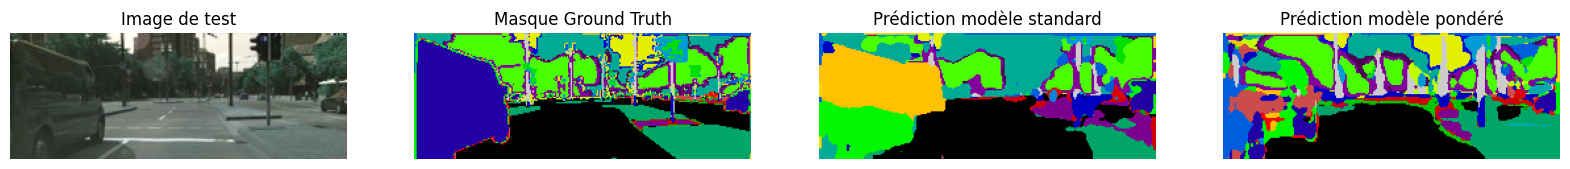

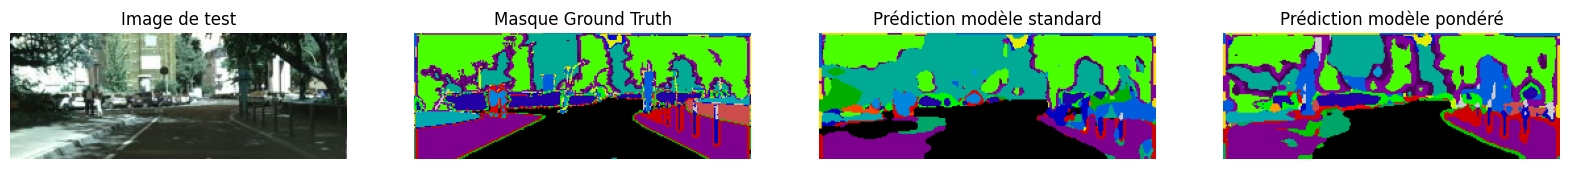

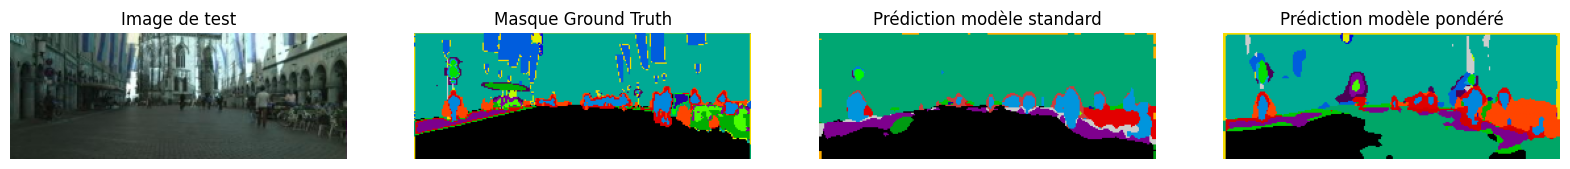

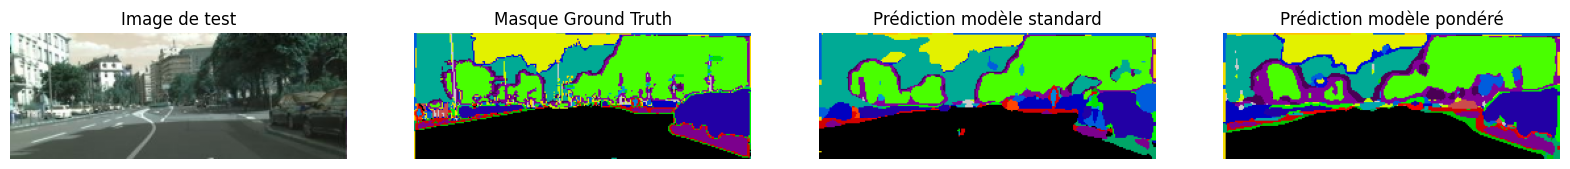

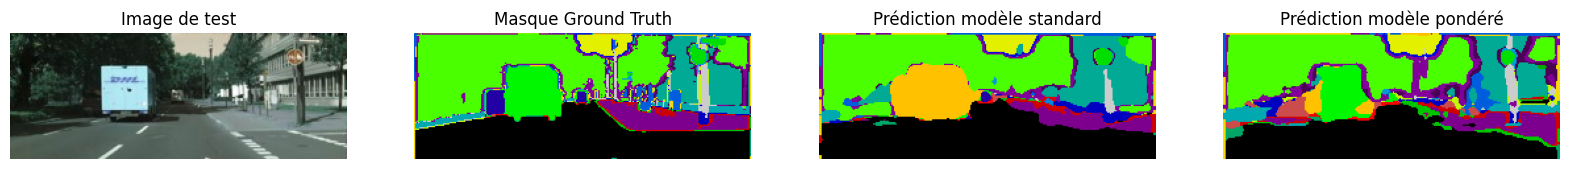

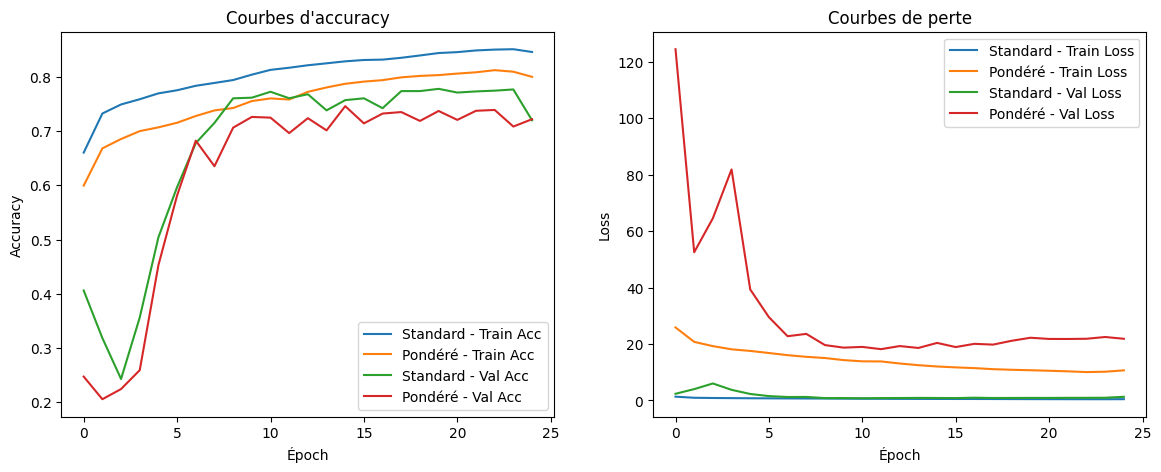


=== Rapport de classification - Modèle standard ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91   3019938
           1       0.28      0.11      0.16    222521
           2       0.66      0.54      0.60    475457
           3       0.37      0.23      0.28    410781
           4       0.87      0.75      0.81    761100
           5       0.16      0.22      0.18    140218
           6       0.48      0.17      0.25     74914
           7       0.44      0.34      0.38    272805
           8       0.44      0.60      0.51    136098
           9       0.19      0.13      0.16     57170
          10       0.58      0.49      0.53     90224
          11       0.65      0.94      0.77   2716935
          12       0.26      0.38      0.31    183600
          13       0.53      0.02      0.04     51777
          14       0.05      0.03      0.04     67491
          15       0.29      0.01      0.01     94144
          16       0.46     

In [ ]:
compare_model_performance(x_test, y_test, predicted_masks, predicted_masks_weighted, history1=history_deeplab, history2=history_deeplab_weighted, class_names=None, num_samples=5)